In [ ]:
!pip install pandas-datareader
!pip install --upgrade ta
!pip install -U git+https://github.com/twopirllc/pandas-ta
!pip install nest-asyncio
!pip install -U git+https://github.com/mariostoev/finviz
!pip install git+git://github.com/peerchemist/finta.git
!pip install tiingo
 
#!pip install pandas_ta
#!pip install robin_stocks
!pip install finviz
!pip install PyPortfolioOpt
!pip install -U yfinance
 
!pip install td-ameritrade-python-api==0.3.5
!pip install selenium
!pip install webdriver_manager
!pip install fracdiff
 
!pip install --upgrade numpy
!pip install pandas==1.3.0

  Cloning https://github.com/twopirllc/pandas-ta to /tmp/pip-req-build-ztbv2vdd
  Running command git clone -q https://github.com/twopirllc/pandas-ta /tmp/pip-req-build-ztbv2vdd
  Cloning https://github.com/mariostoev/finviz to /tmp/pip-req-build-ag9hbpz_
  Running command git clone -q https://github.com/mariostoev/finviz /tmp/pip-req-build-ag9hbpz_
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached beautifulsoup4-4.10.0-py3-none-any.whl (97 kB)
  Using cached tenacity-7.0.0-py2.py3-none-any.whl (23 kB)
  Using cached urllib3-1.26.7-py2.py3-none-any.whl (138 kB)
  Using cached requests-2.26.0-py2.py3-none-any.whl (62 kB)
ERROR: Package 'finviz' requires a different Python: 3.7.12 not in '<4.0,>=3.8'
  Cloning git://github.com/peerchemist/finta.git to /tmp/pip-req-build-s1sq3cts
  Running command git clone -q git://github.com/peerchemist/finta.git /tmp/pip-req-build-s1sq3cts
  Using cached urllib3-

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as pdr
import ta
import pandas_ta 
from pandas import DataFrame, Series
import nest_asyncio
nest_asyncio.apply()
import finviz
from finviz.screener import Screener
from finta import TA
import tiingo
from tiingo import TiingoClient
import requests
from datetime import datetime
from statistics import mean,median
import urllib
from urllib.parse import urlencode, quote_plus
import pypfopt
from pypfopt import objective_functions
 
from google.colab import files
import csv
from collections import OrderedDict
import json
 
#import robin_stocks as rs
from datetime import datetime,timedelta,date
from dateutil import parser
import scipy
from scipy import stats as scipy_stats

 
import yfinance as yf
yf.pdr_override()
 
import td
from td.client import TDClient
 
import requests
from datetime import datetime
from statistics import mean,median
import urllib
from urllib.parse import urlencode, quote_plus
 
import selenium
from selenium import webdriver
from webdriver_manager.opera import OperaDriverManager
import json
from fracdiff import FracdiffStat
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import sklearn
#import portfoliolab


import warnings
warnings.simplefilter("ignore")

In [ ]:
def yahooTA(ticker,freq):
  
  sixty=['1m','2m','5m','15m','30m']

  if freq in sixty:
    data=pdr.get_data_yahoo(ticker,interval=freq,period='60d')
    data.index=data.index.tz_convert('US/Pacific')
  
  elif freq=='1h':
    data=pdr.get_data_yahoo(ticker,interval=freq,period='500d')
    data.index=data.index.tz_convert('US/Pacific')
  
  else:
    data=pdr.get_data_yahoo(ticker,interval=freq)
   
  data=data.drop('Adj Close',axis=1)
  #data=data.reset_index()
  
  data['mfi2']=ta.volume.money_flow_index(high=data['High'],low=data['Low'],close=data['Close'],volume=data['Volume'],window=2)
  data['mfi10']=ta.volume.money_flow_index(high=data['High'],low=data['Low'],close=data['Close'],volume=data['Volume'],window=10)
  
  data['rsi10']=ta.momentum.rsi(close=data['Close'],window=10)
  data['rsi2']=ta.momentum.rsi(close=data['Close'],window=2)            

  data['hma10']=pandas_ta.hma(data['Close'],length=10)
  data['hma20']=pandas_ta.hma(data['Close'],length=20)
  data['hma50']=pandas_ta.hma(data['Close'],length=50)
  
  data['ema10']=pandas_ta.ema(data['Close'],length=10)
  data['ema20']=pandas_ta.ema(data['Close'],length=20)
  data['ema50']=pandas_ta.ema(data['Close'],length=50)

  data['natr']=pandas_ta.natr(data['High'],data['Low'],data['Close'],length=10)

  psar=pandas_ta.psar(data['High'],data['Low'],data['Close'],0.4,0.4,0.4)
    
  psar['PSARl_0.4_0.4'].fillna(psar['PSARs_0.4_0.4'],inplace=True)
  data['psar']=psar['PSARl_0.4_0.4']

  psar=pandas_ta.psar(data['High'],data['Low'],data['Close'],2,2,2)

  psar['PSARl_2.0_2.0'].fillna(psar['PSARs_2.0_2.0'],inplace=True)
  data['stop_loss']=psar['PSARl_2.0_2.0']

  data['hbb']=ta.volatility.bollinger_hband(data['Close'])
  data['lbb']=ta.volatility.bollinger_lband(data['Close'])
     
  data['close_returns']=data.Close.pct_change(periods=1)
  data['price_roc']=data.Close.diff()
  data['vol_roc']=data.Volume.diff().ewm(span=10).mean()

  data['Volume'].iloc[:data['hma10'].isnull().sum()]=data['hma10'].iloc[:data['hma10'].isnull().sum()]

  data['vol_ema']=data['Volume'].ewm(span=10).mean()

  keltner=pandas_ta.kc(data['High'],data['Low'],data['Close'],scale=1.5,mamode='ema')
  keltner.columns=['lkeltner','mkeltner','hkeltner']  

  data=pd.concat([data,keltner],axis=1)

  data['hma_con']=data.hma10.diff().diff()
  data['hma_con_ema']=data.hma_con.ewm(span=10).mean()

  data.columns=[col.lower() for col in data.columns]

  data['cci10']=pandas_ta.cci(data['low'],data['high'],data['close'],length=10)
  data['cci2']=pandas_ta.cci(data['low'],data['high'],data['close'],length=2)

  data['qstick10']=pandas_ta.qstick(data['open'],data['close'],length=10)
  data['qstick2']=pandas_ta.qstick(data['open'],data['close'],length=2)
  data['pct_change']=data['close'].pct_change()

 # data['kvo']=pandas_ta.kvo(data['high'],data['low'],data['close'],data['volume'],fast=20,long=50,length_sig=10)['KVOs_20_55_13']
  #data['eri']=pandas_ta.eri(data['high'],data['low'],data['close'],length=10)
  
  return data

def Prices(stocks_list,freq):

  prices_df=pd.DataFrame()
  sixty=['1m','2m','5m','30m','15m']
  
  for ticker in stocks_list:
    
    if freq in sixty:
      data=pdr.get_data_yahoo(ticker,interval=freq,period='60d')
      data.index=data.index.tz_convert('US/Pacific')
    
    elif freq=='1h':
      data=pdr.get_data_yahoo(ticker,interval=freq,period='710d')
      data.index=data.index.tz_convert('US/Pacific')
    
    else:
      data=pdr.get_data_yahoo(ticker,interval=freq)
      
    prices_df[str(ticker)]=data['Close']
      
    #prices_df=prices_df.dropna(axis=0)

  return prices_df

def yf_fetch(ticker_list):

  returns_df=pd.DataFrame()
  prices_df=pd.DataFrame()

  for ticker in ticker_list:
    data=yf.Ticker(ticker).history(period='max')
    data['returns']=data.Close.pct_change()

    returns_df[str(ticker)]=data['returns']
    prices_df[str(ticker)]=data['Close']
  
  return returns_df,prices_df

def yf_intraday(ticker_list):
  returns_df=pd.DataFrame()
  prices_df=pd.DataFrame()

  for ticker in ticker_list:
    data=yf.Ticker(ticker).history(period='60d',interval='15m')
    data['returns']=data.Close.pct_change()

    returns_df[str(ticker)]=data['returns']
    prices_df[str(ticker)]=data['Close']

  return returns_df,prices_df

def Returns(stocks_list):

  returns_df=pd.DataFrame()
  
  for stock_symbol in stocks_list:
     
    data=pdr.get_data_yahoo(stock_symbol.replace('.',''))
    
    returns_df[str(stock_symbol)]=data['Close'].pct_change()
    
    #prices_df=prices_df.dropna(axis=0)

  return returns_df

def Blacklitter(prices_df,view_dict):
  risk_model=pypfopt.risk_models.CovarianceShrinkage(prices_df)
  cov_matrix=risk_model.oracle_approximating()

  view_series=pd.Series(view_dict)

  #cov_matrix=pypfopt.risk_models.fix_nonpositive_semidefinite(cov_matrix,fix_method='spectral')

  #if np.linalg.det(cov_matrix)==0:
    #cov_matrix=cov_matrix+0.0000001
  
  bl=pypfopt.black_litterman.BlackLittermanModel(cov_matrix=cov_matrix,absolute_views=view_series)

  weights=bl.bl_weights()
  weights=bl.clean_weights(cutoff=0.000001,rounding=8)


  return dict(weights)

In [ ]:
def Blacklitter2(prices_df,views_dict,method):
  view_series=pd.Series(views_dict)
  view_series=view_series[view_series!=0]
  hrp_series=pd.Series(HR_Paritize(prices_df,views_dict,method=method))

  risk_model=pypfopt.risk_models.CovarianceShrinkage(prices_df)
  cov_matrix=risk_model.oracle_approximating()

  repeat=np.array(hrp_series-1/len(hrp_series))
  P=np.vstack([repeat]*len(view_series))
  Q=np.array(view_series).reshape(-1,1)

  bl=pypfopt.black_litterman.BlackLittermanModel(cov_matrix=cov_matrix,Q=Q,P=P)
  weights=bl.bl_weights()
  weights=bl.clean_weights(cutoff=0.000001,rounding=8)

  if np.isinf(pd.Series(weights)).sum()==len(weights):
    one_df=pd.Series([1 if x>0 else -1 for x in pd.Series(weights)],index=weights.keys())
    
    one_df=one_df/(abs(one_df)).sum()
    weights=dict(one_df)

  return dict(weights)

In [ ]:
def tanm(x):
  e=2.71828
  numerator=(e**(15*x)-e**(7.5))
  denominator=(e**(15*x)+e**(7.5))**-1

  if isinstance(x,float)==True:
    if np.isnan(numerator * denominator)==True:
      return 1
    
    else:
      return numerator*denominator
    
  else:
    return numerator*denominator

def scale(entity):
  scaler=MinMaxScaler() #MinMax
  
  if isinstance(entity,pd.DataFrame)==True or isinstance(entity,pd.Series):
    if len(entity.shape)<2:
      scaled=pd.DataFrame(scaler.fit_transform(entity.values.reshape(entity.values.shape+(1,))))
      scaled.index=entity.index
      return scaled
    elif entity.shape[-1]==1:
      scaled=pd.DataFrame(scaler.fit_transform(entity))
      scaled.index=entity.index
      return scaled
    else:
      print('Too many columns')
  
  elif isinstance(entity,pandas.DataFrame)==True or isinstance(entity,pandas.Series):
    if len(entity.shape)<2:
      scaled=pd.DataFrame(scaler.fit_transform(entity.values.reshape(entity.values.shape+(1,))))
      scaled.index=entity.index
      return scaled
    elif entity.shape[-1]==1:
      scaled=pd.DataFrame(scaler.fit_transform(entity))
      scaled.index=entity.index
      return scaled
    else:
      print('Too many columns')
  
  elif isinstance(entity,np.ndarray):
    if len(entity.shape)<2:
      scaled=pd.DataFrame(scaler.fit_transform(entity.reshape(entity.shape+(1,))))
      scaled.index=entity.index
      return scaled
    
    elif len(entity.shape[-1])==1:
      scaled=pd.DataFrame(scaler.fit_transform(entity))
      scaled.index=entity.index
      return scaled
    else:
      print('Too many columns')

def frac_diff(entity):
  entity=entity.dropna()
  scaler=FracdiffStat()
  
  if isinstance(entity,(pd.DataFrame,pd.Series))==True:
    if len(entity.shape)<2:
      scaled=pd.DataFrame(scaler.fit_transform(entity.values.reshape(entity.values.shape+(1,))))
      scaled.index=entity.index
      
      return scaled

    elif entity.shape[-1]==1:
      scaled=pd.DataFrame(scaler.fit_transform(entity))
      scaled.index=entity.index
      return scaled
      
    else:
      print('Too many columns')
  
  elif isinstance(entity,np.ndarray):
    if len(entity.shape)<2:
      scaled=pd.DataFrame(scaler.fit_transform(entity.reshape(entity.shape+(1,))))
      scaled.index=entity.index
      return scaled
    
    elif len(entity.shape[-1])==1:
      scaled=pd.DataFrame(scaler.fit_transform(entity))
      scaled.index=entity.index
      return scaled
    
    else:
      print('Too many columns')

In [ ]:
def engulfing(data): 
  data['engulf_score']=0
  data['engulf_score'][(data.close.shift() < data.open.shift()) & (data.close > data.open.shift())  & (data.open<data.close.shift())]=1
  data['engulf_score'][(data.close.shift() > data.open.shift()) & (data.close < data.open.shift())  & (data.open>data.close.shift())]=-1

  return data['engulf_score']


def dday(data):

  data['dday_score']=0
  
  for i in range(len(data)):
    window=data.iloc[i:i+25]
    neg_counter=0
  
    for i in range(len(window)-1):
      if window['close_returns'].iloc[i+1]<=-0.002 and window['volume'].iloc[i+1]>window['volume'].iloc[i]:
        neg_counter+=1
      
    if neg_counter>=4:
      data['dday_score'].iloc[i+25]=-1
    
  return data['dday_score']


def supertrend(data):
  data['super']=pandas_ta.supertrend(data['high'],data['low'],data['close'],length=2,multiplier=1).iloc[:,1]
  
  return data['super']/2


def bband(data):
  data['bband_score']=0

  data['bband_score'][(data['high']>data['hbb']) & (data['close']<data['hbb'])]=-1

  data['bband_score'][(data['high']>data['hbb']) & (data['close']>data['hbb'])]=1 

  data['bband_score'][(data['low']<data['lbb']) & (data['close']<data['hbb'])]=-1

  data['bband_score'][(data['high']<data['lbb']) & (data['close']>data['hbb'])]=1

  return data['bband_score']

def cci2(data):
  data['cci2_score']=0
  data['cci2_score'][data['cci2']>=65.666667]=-0.5
  data['cci2_score'][data['cci2']<=-65.666667]=0.5

  return data['cci2_score']

def cci10(data):
  data['cci10_score']=0
  data['psar_trend']=Mpsar_trend(data)

  data['cci10_score'][(data['cci10']<=-100) & (data['psar_trend']==1)]=tanm(1-data['mfi10']/100)

  data['cci10_score'][(data['cci10']>=100) & (data['psar_trend']==-1)]=tanm(1-data['mfi10']/100)

  return data['cci10_score']

def klinger(data):
  data['kvo_score']=0

  data['kvo_score'][(data['kvo']>0) & (data['kvo'].shift()<0)]=1
  data['kvo_score'][(data['kvo']<0) & (data['kvo'].shift()>0)]=-1

  return data['kvo_score']


def qstick10(data):
  data['qstick_score']=0
  data['qstick_score'][(data['qstick10']>0) & (data['qstick10'].shift()<0)]=1
  data['qstick_score'][(data['qstick10']<0) & (data['qstick10'].shift()>0)]=-1

  return data['qstick_score']

def qstick2(data):
  data['qstick_score']=0
  data['qstick_score'][(data['qstick2']>0) & (data['qstick2'].shift()<0)]=0.5
  data['qstick_score'][(data['qstick2']<0) & (data['qstick2'].shift()>0)]=-0.5

  return data['qstick_score']


def Mmfi2(data):
  data['mfi2_score']=0
  data['mfi2_score'][data['mfi2']>=95]=-0.5
  data['mfi2_score'][data['mfi2']<=5]=0.5
  
  return data['mfi2_score']

def Mrsi2(data):
  data['rsi2_score']=0
  data['rsi2_score'][data['rsi2']>=95]=-0.5
  data['rsi2_score'][data['rsi2']<=5]=0.5
  
  return data['rsi2_score']

def Mpsar_trend(data):
  data['psar_trend']=0
  data['psar_trend'][data['psar']>data['close']]=-1
  data['psar_trend'][data['psar']<=data['close']]=1

  return data['psar_trend']


def Mmfi10(data):
  data['mfi10_score']=0
  data['psar_trend']=Mpsar_trend(data)

  data['mfi10_score'][((data['mfi10']<=40) | (data['mfi10']>=90)) & (data['psar_trend']==1)]=tanm(1-data['mfi10']/100)
  
  data['mfi10_score'][((data['mfi10']<=10) | (data['mfi10']>=60)) & (data['psar_trend']==-1)]=tanm(1-data['mfi10']/100)
  
  return data['mfi10_score']

def Mrsi10(data):
  data['rsi10_score']=0
  data['psar_trend']=Mpsar_trend(data)
  data['rsi10_score'][((data['rsi10']<=35) | (data['rsi10']>=80)) & (data['psar_trend']==1)]+=tanm(1-data['rsi10']/100)
  
  data['rsi10_score'][((data['rsi10']<=25) | (data['rsi10']>=60)) & (data['psar_trend']==-1)]+=tanm(1-data['rsi10']/100)
  
  return data['rsi10_score']

def Mhma_crossback(data):
  data['hma_score']=0
  data['hma_score'][(data['close']>=data['hma50']) & (data['hma10']>=data['hma20']) & (data['hma10'].shift()<=data['hma20'].shift())]=1
  data['hma_score'][(data['close']<=data['hma50']) & (data['hma10']<=data['hma20']) & (data['hma10'].shift()>=data['hma20'].shift())]=-1

  return data['hma_score']

def Mema_crossback(data):
  data['ema_score']=0
  data['ema_score'][(data['close']>=data['ema50']) & (data['ema10']>=data['ema20']) & (data['ema10'].shift()<=data['ema20'].shift())]+=1
  data['ema_score'][(data['close']<=data['ema50']) & (data['ema10']<=data['ema20']) & (data['ema10'].shift()>=data['ema20'].shift())]+=-1
	
  return data['ema_score']

def Mpsar_reversal(data):
  data['psar_rev']=0
  data['psar_rev'][ (data['close']>data['psar']) & (data['close'].shift()<data['psar'].shift())]+=1
  data['psar_rev'][ (data['close']<data['psar']) & (data['close'].shift()>data['psar'].shift())]+=-1

  return data['psar_rev']

def Msqueezed(data):
  data['squeeze']=0

  data['squeeze'][(data['hbb']>data['hkeltner']) & (data['lbb']<data['lkeltner'])]+=1
  data['squeeze'][(data['hbb']<data['hkeltner']) & (data['lbb']>data['lkeltner'])]+=-1

  return data['squeeze']

def Mmomentum(data,squeeze):
  try:
    roc=data['price_roc'].iloc[-5:].mean()
    
    if abs(squeeze)==1:
      
      return scipy.special.expit(roc)
    
    else:
      return 0
  
  except Exception as e:
    print(e)
    return 0
    pass

def ichimoku(data):

  past,future=pandas_ta.ichimoku(data['high'],data['low'],data['close'])
  past.columns=['spanA','spanB','conversion','base','lag']
  past=past.drop(['lag'],axis=1)
  future.columns=['spanA','spanB']

  ichimoku_df=past.append(future)

  data=pd.concat([data,ichimoku_df],axis=1)
  
  data['ichi_score']=0

  ichi_up=data['ichi_score'][data['close']>data['conversion']][data['close']>data['base']]

  up1=ichi_up[data['close']>data['spanA']][data['spanA']>data['spanB']]+0.5

  up2=ichi_up[data['spanA'].shift(-26)>data['spanB'].shift(-26)][data['spanA'].shift(-25)<=data['spanB'].shift(-25)]+0.5#future

  ichi_down=data['ichi_score'][data['close']<data['conversion']][data['close']<data['base']]

  down1=ichi_down[data['close']<data['spanA']][data['spanA']<data['spanB']]-0.5

  down2=ichi_down[data['spanA'].shift(-26)<data['spanB'].shift(-26)][data['spanA'].shift(-25)>=data['spanB'].shift(-25)]-0.5 #future

  up3=data['ichi_score'][data['close']>data['spanA']][data['spanA']>data['spanB']][data['close'].shift()<=data['spanA'].shift()]+0.5
  down3=data['ichi_score'][data['close']<data['spanA']][data['spanA']<data['spanB']][data['close'].shift()>=data['spanA'].shift()]-0.5

  ichi_list=[data['ichi_score'],up1,up2,up3,down1,down2,down3]

  ichi_scores=pd.concat(ichi_list,axis=1).sum(1)
  
  return ichi_scores.iloc[:-26]

def volume_counter(data):
  try:
    orig_data=data.copy()
    data=data[['volume','vol_ema','close_returns']].iloc[-10:]
  
    data['label']=0
    data['label'][data['close_returns']>0]=1
    data['label'][data['close_returns']<0]=-1
  
    plus_counter=0
    neg_counter=0
  
    for idx in range(len(data)):
      if data['label'].iloc[idx]==1 and data['volume'].iloc[idx]>=data['vol_ema'].iloc[idx]:
        plus_counter+=1
      
      elif data['label'].iloc[idx]==-1 and data['volume'].iloc[idx]>=data['vol_ema'].iloc[idx]:
        neg_counter+=1
      
      else:
        continue
  
    sum_counter=plus_counter-neg_counter
    if (sum_counter>0 and plus_counter>=3) and (psar_trend(orig_data)==1):
      
      return scipy.special.expit(sum_counter)
  
    elif (sum_counter<0 and neg_counter>=3) and (psar_trend(orig_data)==-1):
      return scipy.special.expit(sum_counter)
  
    else:
      return 0
  except:
    return 0
    pass

def psar_trend(data):
  if data['psar'].iloc[-1]>data['close'].iloc[-1]:
    return -1
  else:
    return 1

In [ ]:
def matrix_necklace(data):   

  long_mfi=Mmfi10(data)/3
  long_rsi=Mrsi10(data)/3
  long_cci=cci10(data)/3
  ema_cross=Mema_crossback(data)
  psar=Mpsar_reversal(data)
  hma_cross=Mhma_crossback(data)
  #kling=klinger(data)
  dist=dday(data)
  engulf=engulfing(data)

  
  try:  
    moku=ichimoku(data)
  except:
    moku=pd.Series(np.zeros(len(data)),index=data.index)
    pass

  bollinger=bband(data)
  #vol_count=volume_counter(data)
  
  score_list=[hma_cross,psar,ema_cross,long_mfi,long_rsi,long_cci,bollinger,moku,dist,engulf] #vol_count

  aggregate=sum(score_list)  

  short_rsi=Mrsi2(data)/2
  short_mfi=Mmfi2(data)/3
  short_cci=cci2(data)/3
  #short_q=qstick2(data)/3

  squeeze_df=Msqueezed(data)*Mpsar_trend(data)
  squeeze_df.columns='squeeze'
 
  all_df=pd.concat([data,squeeze_df],axis=1).dropna()
  mom_series=pd.Series(range(len(all_df)),index=all_df.index,name='mom')

  for i in range(len(all_df)):

      squeeze=all_df['squeeze'].iloc[i]
      new_data=all_df[['close','price_roc']].iloc[:i+1]
      
      mom=Mmomentum(new_data,squeeze)
      
      
      mom_series.iloc[i]=mom
  
  tech=[short_rsi,short_mfi,short_cci] #
  aggregate[aggregate!=0]+=sum(tech)
  #aggregate+=sum(tech)

  return aggregate#,pd.concat(score_list,axis=1),pd.concat(tech,axis=1)

def generate_matrix_views(ticker_list,backtest_length,freq):
  data_dict={}

  data_dict['freq']=freq
  views_df=pd.DataFrame()

  for ticker in ticker_list:
    try:
    
      data=yahooTA(ticker,freq)
      
      weekly=yahooTA(ticker,'1wk')

      monthly=yahooTA(ticker,'1mo')
      
      data_dict[ticker]=data

      new_data=data.iloc[-(backtest_length):,:]

      new_weekly=weekly.iloc[-(backtest_length):,:]/2

      new_monthly=monthly.iloc[-(backtest_length):,:]/3
      
      result=matrix_necklace(new_data)

      weekly_result=matrix_necklace(new_weekly)
      
      monthly_result=matrix_necklace(new_monthly)

      new_result=pd.merge_asof(pd.DataFrame(result),pd.DataFrame(weekly_result),right_index=True,left_index=True).sum(1)

      new_result=pd.merge_asof(pd.DataFrame(new_result),pd.DataFrame(monthly_result),right_index=True,left_index=True).sum(1)

      views_df[ticker]=new_result
    
    except:
      pass
  
  return views_df.fillna(0).T,data_dict

In [ ]:
 def HR_Paritize(prices_df,views_dict,method='single'):

    if len(views_dict)==1:
     return {x:1 for x in views_dict}
    
    elif len(views_dict)==0:
      return {}
    
    else:
      
      views_df=pd.Series(views_dict)

      prices_df=prices_df[views_df.index]

      risk_model=pypfopt.risk_models.CovarianceShrinkage(prices_df)
      cov_matrix=risk_model.oracle_approximating()

      hrp=pypfopt.hierarchical_portfolio.HRPOpt(cov_matrix=cov_matrix)

      abs_weights=dict(hrp.optimize(method))
      
      #hrp_weights={x:(-y if views_dict[x]<0 else y) for x,y in abs_weights.items()}
      
      return abs_weights

In [ ]:
def backtest_views(views_df,data_dict,capital,HRP=False,long_only=False,static=False,trail=False,threshold=False,bl1=False,method='ward'): #reverse=False
  column_name='bl'
  freq=data_dict['freq']
 
  for param in backtest_views.__code__.co_varnames:
    try:
      if eval(param)==True:
        print('***'*5,param,'***'*5)
        if column_name=='bl':
          column_name=param+'/'
        else:
          column_name+=param+'/'
    except:
      pass
 
  profit_list=[]
  profit_list.append(capital)

  _,prime_prices_df=yf_fetch(views_df.index)
  
  if freq=='1d':
    prices_df=prime_prices_df.copy()
  
  else:
    prices_df=Prices(views_df.index,freq) 

  views_df.loc[:,(views_df != 0).any(axis=0)]

  for i in range(len(views_df.columns)):
    
    col=str(views_df.columns[i])
      
     
    try:
      
      views_zero=dict(views_df[(col)])

      #print('We are using views of ',str(col)[:10])
      
      views_dict={x:y for x,y in views_zero.items() if y!=0}

      if threshold:
        views_dict={x:y for x,y in views_dict.items() if abs(y)>0.3}
    

      price_df=prices_df.loc[:(col)]
      prime_price_df=prime_prices_df.loc[:(col)[:10]]

      #print('For portfolio optimization,we use returns/prices of up to',str(col)[:10])
      
      if HRP and not long_only:
        
        neg_dict={x:y for x,y in views_dict.items() if y<0}
        pos_dict={x:y for x,y in views_dict.items() if y>0}
        pos_weights=HR_Paritize(prime_price_df,pos_dict,method)
        neg_weights=HR_Paritize(prime_price_df,neg_dict,method)
        neg_weights={x:-y for x,y in neg_weights.items()}
        comb_weights={**pos_weights,**neg_weights}
        #abs_weights=HR_Paritize(prime_price_df,views_dict)
        #hrp_weights={x:(-y if views_dict[x]<0 else y) for x,y in abs_weights.items()}
        
        weights=comb_weights.copy()
        #weights=hrp_weights.copy()

      elif HRP and long_only:
        
        views_dict={x:y for x,y in views_dict.items() if y>0}

        if len(views_dict)>1:
          weights=HR_Paritize(prime_price_df,views_dict,method)
      
        elif len(views_dict)==1:
          weights={x:1 for x in views_dict}
        
        else:
          profit_list.append(0)
          continue
                
      else:
        if bl1:
          bl_weights=Blacklitter(prime_price_df[views_dict.keys()],views_dict)
        else:
          bl_weights=Blacklitter2(prime_price_df[views_dict.keys()],views_dict,method) 
        weights=bl_weights.copy()
        if not HRP and long_only:
          weights_df=pd.Series(weights)
          if len(weights_df[weights_df>0])>0:
            weights=dict((weights_df[weights_df>0])) 
        
          else:
            profit_list.append(0)
            continue
        
      #print('The prices used for share calculation are from',last_prices.name)
      
      weights_df=pd.Series(weights)
      weights_df=weights_df[weights_df!=0]

      if abs(weights_df).sum()!=1:
        corrected_df=weights_df/abs(weights_df).sum()
        
        #weights=dict(corrected_df)
      
      else:
        corrected_df=weights_df

      sign_df=weights_df/abs(weights_df)
      weights=dict(abs(corrected_df))

      last_prices=price_df.iloc[-1,:]
      sharer=pypfopt.discrete_allocation.DiscreteAllocation(weights,last_prices.dropna(),capital,0.000001) #0.000001

      shares_dict=sharer.greedy_portfolio()[0]
      
      shares_dict={key:shares_dict[key]*sign_df[key] for key in shares_dict}
      
      profit_dict=backtest(shares_dict,data_dict,views_df,i,trail=trail) 
      
      profit_loss=sum(profit_dict.values())

      profit_list.append(profit_loss)
  
      if (profit_loss/capital)<-0.2:
        print('Loss incurred from TA based on',last_prices.name)

      elif (profit_loss/capital)>0.2:
        print('huge gain with')
        print(shares_dict,last_prices.name)
        print('weights',weights)
        print(i)

      if not static:
        capital+=profit_loss
        
      if capital<0:
        print('Failed') 
        late=views_df.columns[:i+1]+pd.Timedelta('1 day')
        late=late.insert(0,views_df.columns[0])
        
        return pd.DataFrame(profit_list,columns=[column_name],index=late)
        
    except Exception as e:
      print(e)
      profit_list.append(0)
      pass
       
  late=views_df.columns+pd.Timedelta('1 day')
  late=late.insert(0,views_df.columns[0])
 
  return pd.DataFrame(profit_list,columns=[column_name],index=late)
 
def backtest(shares_dict,data_dict,views_df,i,trail=False):
  
  #print('shares_dict',shares_dict)
  profit_dict={}
 
  col1=str(views_df.columns[i+1])#[:10]
  col2=str(views_df.columns[i])#[:10]
 
  #print('We backtest differences ending on',col1)
  for ticker in shares_dict:
    #try:
    data=data_dict[ticker]

    if not trail:
    #print('We use stop_losses calculated on',col2)
 
      psar_return=abs(data.close.loc[col2]- data.stop_loss.loc[col2])
      
      current_return = data['price_roc'].loc[col1]
      #print('max return is',abs(current_return),ticker)

      if shares_dict[ticker]>0:
        if current_return < -psar_return:
          designated_return=-psar_return
        else:
          designated_return=current_return
  
      elif shares_dict[ticker]<0:
        if current_return > psar_return:
          designated_return=psar_return
        else:
          designated_return=current_return
        
      #except:
        # pass
  
      ticker_net=shares_dict[ticker]*designated_return
      profit_dict[ticker]=ticker_net
  
      
    elif trail:
      
      current_return = data['pct_change'].shift(-1).loc[col1]
      current_price=data['close'].shift(-1).loc[col2]
      #print('max return is',abs(current_return),ticker)

      if shares_dict[ticker]>0:
        if current_return < -0.04:
          designated_return=-0.04
        else:
          designated_return=current_return
  
      elif shares_dict[ticker]<0:
        if current_return > 0.04:
          designated_return=0.04
        else:
          designated_return=current_return
      
      ticker_net=shares_dict[ticker]*designated_return*current_price
      profit_dict[ticker]=ticker_net
    
      '''current_return = data['pct_change'].loc[col1]
      current_price=data['close'].loc[col2]
      ticker_net=shares_dict[ticker]*current_return*current_price
      profit_dict[ticker]=ticker_net'''

  return profit_dict

In [ ]:
def norm(x):
    
    nom = (x - x.min())*1.33
    denom = x.max() - x.min()
    return  nom/denom

In [ ]:
#ticker_list=['nvda','shop','ba','aapl','tsla','msft','fb','amzn','goog','alb','ba','amd','gold','xom','ge','ibm','jnj','gm','wmt','ko','intc','hd','orcl','dis']
ticker_list=['eth-usd', 'btc-usd', 'ada-usd', 'doge-usd', 'ltc-usd', 'bch-usd', 'dot1-usd','sol1-usd','matic-usd','link-usd','etc-usd','xlm-usd','fil-usd']

In [ ]:
ticker_list=['vrtx','calx','aeis','vivo','dell','acls','amat','mitk','hibb','hear','nx','prg','lh','stc','drd','bgfv','lake','lpx','bdsi','agco','exp','pki','tsla','goog','leu','msft','xom'] #rvlv

In [ ]:
views_df,data_dict=generate_matrix_views(ticker_list,400,'1d')

In [ ]:
bl2=backtest_views(views_df,data_dict,35000,trail=True,static=True,threshold=True)
 
hrp=backtest_views(views_df,data_dict,35000,HRP=True,trail=True,static=True,threshold=True)
 
bl_long2=backtest_views(views_df,data_dict,35000,long_only=True,trail=True,static=True,threshold=True)
 
hrp_long=backtest_views(views_df,data_dict,35000,HRP=True,long_only=True,trail=True,static=True,threshold=True)
 
bl1=backtest_views(views_df,data_dict,35000,trail=True,threshold=True,bl1=True)
 
bl_long1=backtest_views(views_df,data_dict,35000,long_only=True,trail=True,threshold=True,bl1=True,static=True)

*************** static ***************
*************** trail ***************
*************** threshold ***************
index 400 is out of bounds for axis 0 with size 400
*************** HRP ***************
*************** static ***************
*************** trail ***************
*************** threshold ***************
index 400 is out of bounds for axis 0 with size 400
*************** long_only ***************
*************** static ***************
*************** trail ***************
*************** threshold ***************
index 400 is out of bounds for axis 0 with size 400
*************** HRP ***************
*************** long_only ***************
*************** static ***************
*************** trail ***************
*************** threshold ***************
index 400 is out of bounds for axis 0 with size 400
*************** trail ***************
*************** threshold ***************
*************** bl1 ***************
cannot convert float NaN to integer
********

bl2          73.628592
_           113.376581
bl1         433.993662
bl_long1    187.902239
bl_long2    165.458014
hrp_long    181.348943
dtype: object


,bl2,_,bl1,bl_long1,bl_long2,hrp_long
mech,23.165298,27.456947,16.706989,16.191022,14.198645,16.426564
sortino,26.841801,31.247925,17.661439,17.637329,15.580431,17.754958
sharpe,1.738611,2.026551,4.906045,2.805378,2.518979,2.638434
avg_gain,216.046241,212.717812,843.727342,439.209008,493.61769,397.260395
avg_drawdown,-136.481397,-86.799734,-439.891453,-296.36774,-349.920965,-225.620844
drawdown_rate,0.40399,0.331671,0.319202,0.341646,0.389027,0.346633
exp_drawdown,-55.137123,-28.788939,-140.414229,-101.252819,-136.128854,-78.207724
kelly,0 0.308017 dtype: float64,0 0.492481 dtype: float64,0 0.520295 dtype: float64,0 0.469466 dtype: float64,0 0.349794 dtype: float64,0 0.457692 dtype: float64


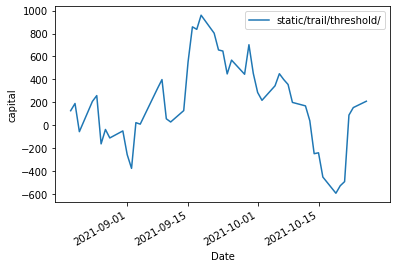

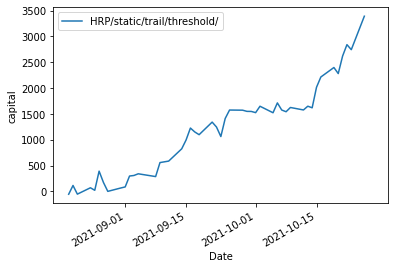

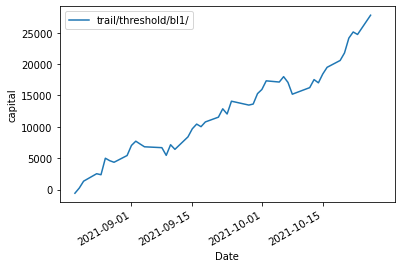

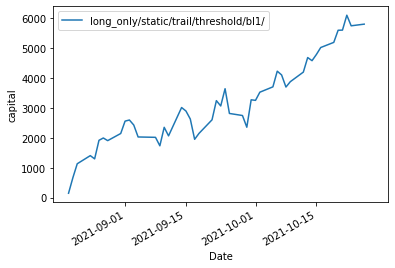

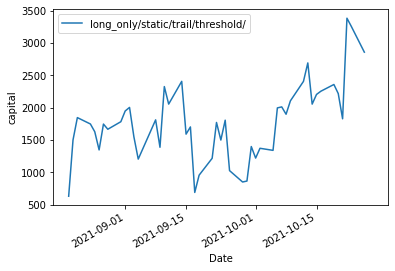

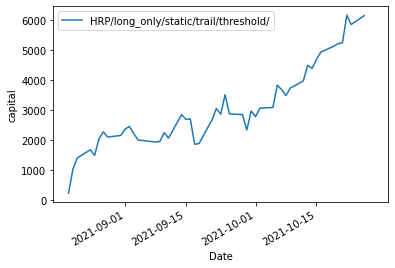

In [ ]:
profits=[bl2,hrp,bl1,bl_long1,bl_long2,hrp_long]  
 
for i in profits:
  plotter(i[-50:])
 
ratings=pd.concat([summarizer(i) for i in profits],axis=1)   
 
print(ratings.loc['avg_gain']*(1-ratings.loc['drawdown_rate'])+ratings.loc['avg_drawdown']*ratings.loc['drawdown_rate'])

ratings

In [ ]:
trials_returns=pd.concat(profits,axis=1).cumsum().pct_change().dropna()

deflated_sharpe_ratio(trials_returns,expected_mean_sr=0.25,returns_selected=trials_returns)

In [ ]:
def estimated_sortino_ratio_stdev(returns=None, *, n=None, skew=None, kurtosis=None, sr=None):
    """
    Calculate the standard deviation of the sharpe ratio estimation.
    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame
        If no `returns` are passed it is mandatory to pass the other 4 parameters.
    n: int
        Number of returns samples used for calculating `skew`, `kurtosis` and `sr`.
    skew: float, np.array, pd.Series, pd.DataFrame
        The third moment expressed in the same frequency as the other parameters.
        `skew`=0 for normal returns.
    kurtosis: float, np.array, pd.Series, pd.DataFrame
        The fourth moment expressed in the same frequency as the other parameters.
        `kurtosis`=3 for normal returns.
    sr: float, np.array, pd.Series, pd.DataFrame
        Sharpe ratio expressed in the same frequency as the other parameters.
    Returns
    -------
    float, pd.Series
    Notes
    -----
    This formula generalizes for both normal and non-normal returns.
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1821643
    """
    if type(returns) != pd.DataFrame:
        _returns = pd.DataFrame(returns)
    else:
        _returns = returns.copy()

    if n is None:
        n = len(_returns)
    if skew is None:
        skew = pd.Series(scipy_stats.skew(_returns), index=_returns.columns)
    if kurtosis is None:
        kurtosis = pd.Series(scipy_stats.kurtosis(_returns, fisher=False), index=_returns.columns)
    if sr is None:
        sr = estimated_sortino_ratio(_returns)

    sr_std = np.sqrt((1 + (0.5 * sr ** 2) - (skew * sr) + (((kurtosis - 3) / 4) * sr ** 2)) / (n - 1))

    if type(returns) == pd.DataFrame:
        sr_std = pd.Series(sr_std, index=returns.columns)
    elif type(sr_std) not in (float, np.float64, pd.DataFrame):
        sr_std = sr_std.values[0]

    return sr_std

def num_independent_trials(trials_returns=None, *, m=None, p=None):
    """
    Calculate the number of independent trials.
    
    Parameters
    ----------
    trials_returns: pd.DataFrame
        All trials returns, not only the independent trials.
        
    m: int
        Number of total trials.
        
    p: float
        Average correlation between all the trials.
    Returns
    -------
    int
    """
    if m is None:
        m = trials_returns.shape[1]
        
    if p is None:
        corr_matrix = trials_returns.corr()
        p = corr_matrix.values[np.triu_indices_from(corr_matrix.values,1)].mean()
        
    n = p + (1 - p) * m
    
    n = int(n)+1  # round up
    
    return n

def deflated_sortino_ratio(trials_returns=None, returns_selected=None, expected_mean_sr=0.0, *, expected_max_sr=None):

  if expected_max_sr is None:
      expected_max_sr = expected_maximum_sr(trials_returns, expected_mean_sr)
      
  dsr = probabilistic_sortino_ratio(returns=returns_selected, sr_benchmark=expected_max_sr)

  return dsr


def estimated_sortino_ratio(returns):
   
  #return kelly_perc(returns)
        
  return returns.mean()/ returns[returns<0].std(ddof=1)#/abs(returns[returns<0].mean())
    


def expected_maximum_sr(trials_returns=None, expected_mean_sr=0.0, *, independent_trials=None, trials_sr_std=None):

  emc = 0.5772156649 # Euler-Mascheroni constant
    
  if independent_trials is None:
      independent_trials = num_independent_trials(trials_returns)
  
  if trials_sr_std is None:
      srs = estimated_sortino_ratio(trials_returns)
      trials_sr_std = srs.std()
  
  maxZ = (1 - emc) * scipy_stats.norm.ppf(1 - 1./independent_trials) + emc * scipy_stats.norm.ppf(1 - 1./(independent_trials * np.e))
  expected_max_sr = expected_mean_sr + (trials_sr_std * maxZ)
  
  return expected_max_sr

def probabilistic_sortino_ratio(returns=None, sr_benchmark=0.0, *, sr=None, sr_std=None):

  if sr is None:
      sr = estimated_sortino_ratio(returns)
  if sr_std is None:
      sr_std = estimated_sortino_ratio_stdev(returns, sr=sr)

  psr = scipy_stats.norm.cdf((sr - sr_benchmark) / sr_std)

  if type(returns) == pd.DataFrame:
      psr = pd.Series(psr, index=returns.columns)
  elif type(psr) not in (float, np.float64):
      psr = psr[0]

  return psr

In [ ]:
def summarizer(df):
  
  prof_series=pd.Series(name=namestr(df,globals())[0])
  #prof_series=pd.Series()
  prof_series['mech']=mech_ratio(df)
  prof_series['sortino']=sortino_ratio(df)
  prof_series['sharpe']=sharpe_ratio(df)
  prof_series['avg_gain']=df[1:][df>0].median().item()
  prof_series['avg_drawdown']=df[df<0].median().item()
  prof_series['drawdown_rate']=len(np.where(df<0)[0])/len(df)
  prof_series['exp_drawdown']=prof_series['drawdown_rate'].item()* prof_series['avg_drawdown'].item()
  prof_series['kelly']=kelly_perc(pd.DataFrame(df))

  return prof_series

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def plot(df):
  plt.plot(df.cumsum())
  plt.ylabel='capital'
  plt.xticks(rotation=90)


def plotter(df): 
  df.cumsum().plot(ylabel='capital')

def kelly_perc(returns):

  kelly_list=[]
  for col in returns.columns:
    returned=returns[col]
    winrate=len(np.where(returned>0)[0])/len(returned)
    loserate=1-winrate

    winloss=winrate/loserate
    kelly=winrate-(1-winrate)/winloss
    kelly_list.append(kelly)
  
  return pd.Series(kelly_list)
 
def sortino_ratio(df):
  daily_return=df.mean()
 
  neg_df=df[df<0].dropna()
  
  neg_std=neg_df.std()
 
  return (daily_return*np.sqrt(52*5)/neg_std).item()
  
 
def mech_ratio(df):
  daily_return=df.mean()
  below_df=df[df<df.mean()].dropna()
  neg_df=df[df<0].dropna()
 
  below_std=below_df.std()
  neg_std=neg_df.std()
  daily_vol=(below_std+neg_std)/2
 
  return (daily_return*np.sqrt(52*5)/daily_vol).item()
 
def sharpe_ratio(df):
  daily_return=df.mean()
 
  daily_vol=df.std()
 
  return (daily_return*np.sqrt(52*5)/daily_vol).item()
 
def d2ar(dollar_daily,capital):
  daily_return=dollar_daily/capital
 
  annual_return=((daily_return+1)**(52*5)-1)*100
 
  print(annual_return,'percent')

def annotations(ticker_list,profits,indicators,freq):
    
  ticker_list=str(ticker_list).replace(' ','')
  
  for i in profits:
    algo=i.columns[0]
    title=indicators+freq+algo+ticker_list
    i.columns=[title]
  
  all_df=pd.concat(profits,axis=1)
  
  event=str(datetime.now())
    
  all_df.to_csv('drive/My Drive/Sharpes/{}'.format(event))

def Backtest_Trip(freq):
  
  #short_list=['nvda','shop','ba','aapl','tsla','msft','fb','amzn','goog','alb','ba','amd','gold']

  liquid_list=['nvda','shop','ba','aapl','tsla','msft','fb','amzn','goog','alb','ba','amd','gold','xom','ge','ibm','jnj','gm','wmt','ko','intc','hd','orcl','dis']
    
  indicators=input()

  for ticker_list in [liquid_list]: #short_list
    views_df,data_dict=generate_matrix_views(ticker_list,1500,freq)
    
    #bl_trail=backtest_views(views_df,data_dict,35000,static=True,trail=True,long_only=True)

    hrp_trail=backtest_views(views_df,data_dict,35000,HRP=True,static=True,trail=True,long_only=True) 
  
    profits=[hrp_trail]
    
    annotations(ticker_list,profits,indicators,freq)

In [ ]:
def Upload_DF(): #should only give ltgr, and price % of 52w High
  
  uploaded=files.upload()
  df_name=list(uploaded.keys())[0]

  row_lst=[]
  csv_file=open(df_name)
  reader=csv.reader(csv_file)
  for entry in reader:
    row_lst.append(entry)
  
  orig_df=pd.DataFrame(row_lst)

  orig_df.columns=orig_df.iloc[0,:]

  orig_df.index=orig_df.iloc[:,0]

  orig_df=orig_df.iloc[1:,1:]

  return orig_df  

def preprocess_ltgr(df):
  tickers=[i.partition(':')[-1].replace('.','') for i in df['Full Ticker']]
  df.index=tickers
  
  df['Long Term Earnings Growth Rate']=pd.to_numeric(df['Long Term Earnings Growth Rate'],errors='coerce')
  
  for i in np.where(df['Long Term Earnings Growth Rate'].isnull())[0]:
    try:
      ticker=df.iloc[i].name

      stock_info=finviz.get_stock(ticker)
      ltgr=(float(str(stock_info['EPS next Q']))+(float(stock_info['EPS next Y'].strip('%'))/100.0) +float(str(stock_info['EPS (ttm)'])))/3
               
      df['Long Term Earnings Growth Rate'].iloc[i]=ltgr
    
    except:
      print('Manually input the ltgr of ',ticker)
      manual_ltgr=input()

      df['Long Term Earnings Growth Rate'].iloc[i]=float(manual_ltgr)
  
  df['Market_Cap']=0
  for ticker in df.index:
    caps=pdr.get_quote_yahoo(ticker.replace('.',''))['marketCap']
    df['Market_Cap'].loc[ticker]=caps.item()
  
  return df

In [ ]:
import glob

def Sortino_Analysis(long_only=False,not_trail=False):

  file_names=glob.glob('drive/MyDrive/Sharpes/*')

  all_df=pd.DataFrame()
  #all_df.index=pd.read_csv(file_names[0])['Date']


  for name in file_names:
    df=pd.read_csv(name)

    #df.index=df.Date

    df=df.drop(['Date'],axis=1)

    all_df=pd.concat([all_df,df],axis=1)
  
  if not_trail:
    not_trail=[col for col in all_df.columns if 'HRP' not  in col]
    all_df=all_df[not_trail]

  
  if long_only:
    longs=[col for col in all_df.columns if '/long_' in col]

    all_df=all_df[longs]

    all_df=all_df.sort_index().dropna()

    columns=all_df.columns

    #thirty=pd.DataFrame([35000 for x in range(all_df.shape[-1])]).T

    all_df.columns=range(len(all_df.columns))

    #new_df=pd.concat([thirty,all_df])

    new_df=all_df.copy()

    all_df=new_df.copy()
    all_df.columns=columns

    trials_returns=new_df.cumsum().pct_change().dropna()
    dsr_series=deflated_sortino_ratio(trials_returns,expected_mean_sr=1.5,returns_selected=trials_returns)

    return dsr_series.sort_values(),all_df,trials_returns
    
  
  all_df=all_df.sort_index().dropna()
  #all_df=pd.concat([all_df[col] for col in all_df.columns if len(all_df[col][all_df[col]==0])<5],axis=1)
  all_df=pd.concat([all_df[col] for col in all_df.columns if (len(all_df[col])-np.count_nonzero(all_df[col]))<3],axis=1)
  all_df=pd.concat([all_df.iloc[i,:] for i in range(all_df.shape[0]) if (all_df.iloc[i,:]==0).sum()<5],axis=1).T
  
  sub_df=all_df.copy()
  sub_df.columns=range(len(sub_df.columns))
  trials_returns=sub_df.cumsum().pct_change().dropna()
  
  dsr_series=deflated_sortino_ratio(trials_returns,expected_mean_sr=0.8,returns_selected=trials_returns)

  return dsr_series.sort_values(),all_df,trials_returns

In [ ]:
sort,all_df,trials_returns=Sortino_Analysis(not_trail=True)
#all_df.columns=range(len(all_df.columns))